## Temp

In [4]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Read the csv files and index appropriately.
ratings_small_df = pd.read_csv('./data/ratings_small.csv')
ratings_df = pd.read_csv('./data/ratings.csv')
links_small_df = pd.read_csv('./data/links_small.csv')
links_df = pd.read_csv('./data/links.csv')
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')
# Reading the movies_metadata.csv file throws a DtypeWarning.
# TODO: Make sure that doesn't matter.

C:\Users\chris\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
dataframes = (ratings_small_df, ratings_df, links_small_df, links_df, keywords_df, credits_df, metadata_df)
# Pandas DataFrames don't have name attributes.
df_names = ("ratings_small", "ratings", "links_small", "links", "keywords", "credits", "movies_metadata")

In [56]:
# Print the names of all the features in each file.
for df, name in zip(dataframes, df_names):
    print("\n" + "Dataframe: " + name + "\nNaN Values:")
    print(df.isnull().sum())


Dataframe: ratings_small
NaN Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Dataframe: ratings
NaN Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Dataframe: links_small
NaN Values:
movieId     0
imdbId      0
tmdbId     13
dtype: int64

Dataframe: links
NaN Values:
movieId      0
imdbId       0
tmdbId     219
dtype: int64

Dataframe: keywords
NaN Values:
id          0
keywords    0
dtype: int64

Dataframe: credits
NaN Values:
cast    0
crew    0
id      0
dtype: int64

Dataframe: movies_metadata
NaN Values:
adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_co

In [61]:
# links_small has some NaN values. Print the unique values to see what we're expecting. 
print(links_small_df.tmdbId.unique())
# It's in the tmdbId column, which seem to be ID numbers for some movies.
# We probably won't use links in actual analysis, so I'm not going to worry about it.

[    862.    8844.   15602. ...,  391698.  137608.  410803.]


In [66]:
# Lots of NaNs in movie_metadata, just print out the first couple of entries to see what's going on.
metadata_df.head(2)
# belongs_to_collection seems fine, that's not simple data and is probably just Python being confused about what to expect.
# homepage throws NaN when there's not a homepage it seems. Probably want to do a one-hot replacement here.
# imdb_id is missing 17 IDs, we should probably just drop these movies.
# original_language: 11, just drop them.
# overview:
# popularity: 5, just drop them.
# poster_path:
# production (general): Just names of companies/countries. Just drop the 3 movies.
# release_date: should probably just drop the samples with missing values, I can't think of a way to fill in the values.
# revenue, spoken languages, title, video, votes all have 6 NaNs. I'd wager they're the same movies, we should drop the samples.
# runtime: We can probably just fill in with a mean/median.
# status: We should do some sort of hot-encoding here, then the NaNs will just be columns of 0. Will print uniques to check.
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence one-hot variable

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [67]:
print(metadata_df.status.unique())
# 6 one-hot variables don't seem too bad. It's an option.

['Released' nan 'Rumored' 'Post Production' 'In Production' 'Planned'
 'Canceled']


In [33]:
for df, name in zip(dataframes, df_names):
    print("\n" + "Dataframe: " + name + "\n")
    print(df.describe())


Dataframe: ratings_small

              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09

Dataframe: ratings

             userId       movieId        rating     timestamp
count  2.602429e+07  2.602429e+07  2.602429e+07  2.602429e+07
mean   1.350371e+05  1.584911e+04  3.528090e+00  1.171258e+09
std    7.817620e+04  3.108526e+04  1.065443e+00  2.052889e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    6.716400e+04  1.073000e+03  3.000000e+00  9.907545

In [50]:
"""
for df, name in zip(dataframes, df_names):
    plt.figure()
    #print("\n" + "Dataframe: " + name + "\n")
    df.hist(figsize=(8,8))
"""

'\nfor df, name in zip(dataframes, df_names):\n    plt.figure()\n    #print("\n" + "Dataframe: " + name + "\n")\n    df.hist(figsize=(8,8))\n'

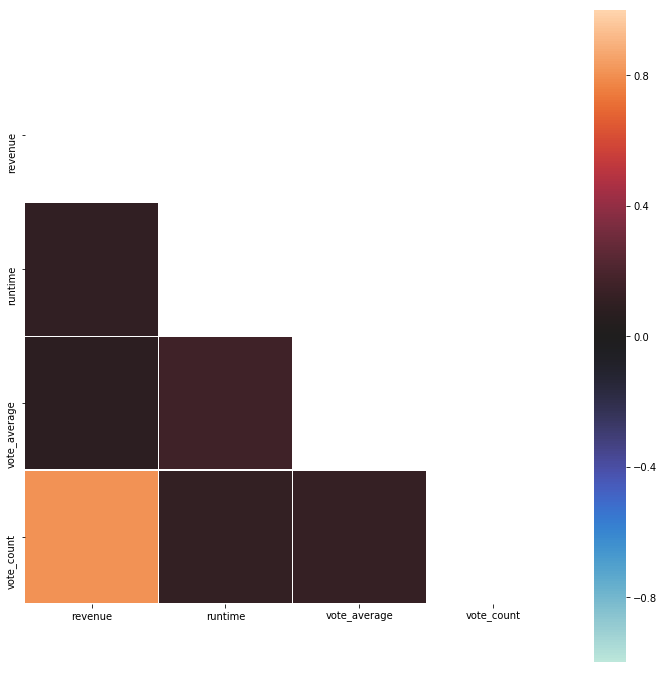

In [70]:
# A quick heatmap of movie_metadata. It seems revenue and the number of votes are correlated.
import seaborn as sns
corr = metadata_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 12))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=False, linewidths=0.2, center=0)